# Dataset Insights

## Baseline
- **F1 Score**: 0.503  
- **ROC AUC**: 0.667 (optional)

## Data
You will be provided with two datasets:

- **train_data.csv**: Use this dataset for training your model.
- **test_data.csv**: Use this dataset for evaluation and comparison with the baseline.

### Columns Description
- **target**: The target variable indicating if the bid won (1) or lost (0).
- **flr**: Floor price set by the publisher/exchange for the ad space.
- **sellerClearPrice**: The price at which the seller is ready to sell the ad-space.
- **hour**: The hour of the day the auction took place.
- **ssp**: The Supply-Side Platform managing the auction.
- **dsp**: The Demand-Side Platform participating in the auction.
- **auctionBidFloorSource**: Source of the bid floor.
- **sdk**: Software Development Kit used in the ad request.
- **sdkver**: Version of the SDK.
- **bundle**: The app bundle identifier.
- **os**: Operating system of the user's device.
- **lang**: Language setting of the user's device.
- **country**: Country from which the bid request originated.
- **region**: Region within the country.
- **request_context_device_w**: Width of the user's device screen.
- **request_context_device_h**: Height of the user's device screen.
- **bidderFlrPolicy**: Bidder's floor price policy.
- **adt**: Ad type requested.
- **dc**: Data center handling the request.
- **contype**: Connection type.
- **request_context_device_type**: Type of the user's device.
- **ifa**: Identifier for Advertisers (unique user identifier).
- **price**: The final bid price submitted.


# Imports

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from polars import StringCache
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import gc

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

# Import helper functions
from src.data_preprocessing.cleaner import PolarsLoader
from src.utils.helpers import InitialEDA

In [2]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Polars version {pl.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 2.0.2
Pandas version 2.2.3
Polars version 1.9.0


In [3]:
DATA_PATH = os.path.join(ROOT, "data")

TRAIN_FILE = os.path.join(DATA_PATH, "train_data.csv")
TEST_FILE = os.path.join(DATA_PATH, "test_data.csv") 

# Data Loading
## With some initial proccessing for memmory efficiency

Had to implement here a "polars loader" because my PC cannot load the whole file

In [4]:
%%time

loader = PolarsLoader(sampling=False)
pl_train, CAT_COLS, NUM_COLS = loader.initial_preprocessing(TRAIN_FILE)
pl_test, _, _ = loader.initial_preprocessing(TEST_FILE)
# gc.collect()

#Print data information
print(f"Train data shape: {pl_train.shape}")
print(f"Test data shape: {pl_test.shape}")

print(f"Number of categorical columns: {len(CAT_COLS)}")
print(f"Number of numerical columns: {len(NUM_COLS)}")
print(f"% target distribution in train data: {pl_train['target'].value_counts(normalize=True)}")

print("*"*50)
print("DATASET IS HIGHLY IMBALANCED")
print("*"*50)


## No batch loading
# CPU times: user 6.22 s, sys: 1.82 s, total: 8.04 s
# Wall time: 1.56 s

## Batch loading
# CPU times: user 5.21 s, sys: 677 ms, total: 5.89 s
# Wall time: 964 ms

Train data shape: (9640735, 17)
Test data shape: (1500000, 17)
Number of categorical columns: 9
Number of numerical columns: 7
% target distribution in train data: shape: (2, 2)
┌────────┬────────────┐
│ target ┆ proportion │
│ ---    ┆ ---        │
│ i16    ┆ f64        │
╞════════╪════════════╡
│ 1      ┆ 0.083195   │
│ 0      ┆ 0.916805   │
└────────┴────────────┘
**************************************************
DATASET IS HIGHLY IMBALANCED
**************************************************
CPU times: user 30.2 s, sys: 13.5 s, total: 43.6 s
Wall time: 11.7 s


# Data Exploratory Analysis

In [5]:
df = pl_train.to_pandas()
df.head()

,target,flr,sellerClearPrice,hour,dsp,auctionBidFloorSource,sdkver,bundle,os,lang,country,region,request_context_device_w,request_context_device_h,bidderFlrPolicy,contype,request_context_device_type,price
0,0,1.651717,1.227061,0,80,rollouts,2.4.0.2,EPcMMU786QLAISLs22Ju,ios,en,US,nc,834,1194,ascending auction,2,5,1.651717
1,0,5.388000,5.709376,3,80,rollouts,2.4.0.2,EPcMMU786QLAISLs22Ju,ios,en,US,sc,390,844,original,2,4,7.685255
2,0,1.010250,1.728341,8,80,rollouts,2.4.0.2,EPcMMU786QLAISLs22Ju,ios,en,US,nv,393,852,original,2,4,2.326478
3,0,0.741433,0.547470,12,80,rollouts,2.4.0.2,EPcMMU786QLAISLs22Ju,ios,en,MX,coa,414,896,ascending auction,2,4,0.756278
4,0,1.010250,1.721669,0,80,rollouts,2.4.0.2,EPcMMU786QLAISLs22Ju,ios,en,US,il,414,896,original,2,4,2.317498


## Categorical

In [6]:
for col in CAT_COLS:
    print(df[col].value_counts(normalize=True))
    print("-"*50)

auctionBidFloorSource
rollouts    0.550928
ml          0.322235
lurl        0.080041
user_ml     0.043245
original    0.003551
Name: proportion, dtype: float64
--------------------------------------------------
sdkver
2.4.0.2    0.657628
2.5.0      0.267954
2.4.0.0    0.022870
2.2.0      0.016295
2.3.3      0.011848
2.1.0.0    0.008563
2.3.0.2    0.003146
1.9.5.0    0.002855
2.0.0.6    0.002671
1.9.4.1    0.001901
2.0.0.5    0.001408
2.1.9      0.001020
2.1.5      0.001000
1.9.10     0.000840
unknown    0.000001
Name: proportion, dtype: float64
--------------------------------------------------
bundle
EPcMMU786QLAISLs22Ju    0.699871
qdQlw0hfUdTmDmhGvCDA    0.289219
zS-DY2RJT9OPsWrTgTGM    0.009739
quPjmKzLzzBxfdYGXiIh    0.001171
Name: proportion, dtype: float64
--------------------------------------------------
os
ios        0.701042
android    0.298958
Name: proportion, dtype: float64
--------------------------------------------------
lang
en                 0.619911
es             

In [7]:
# InitialEDA.plot_barplots_normalized(df, cat_cols=CAT_COLS, exclude=[])

## Integer

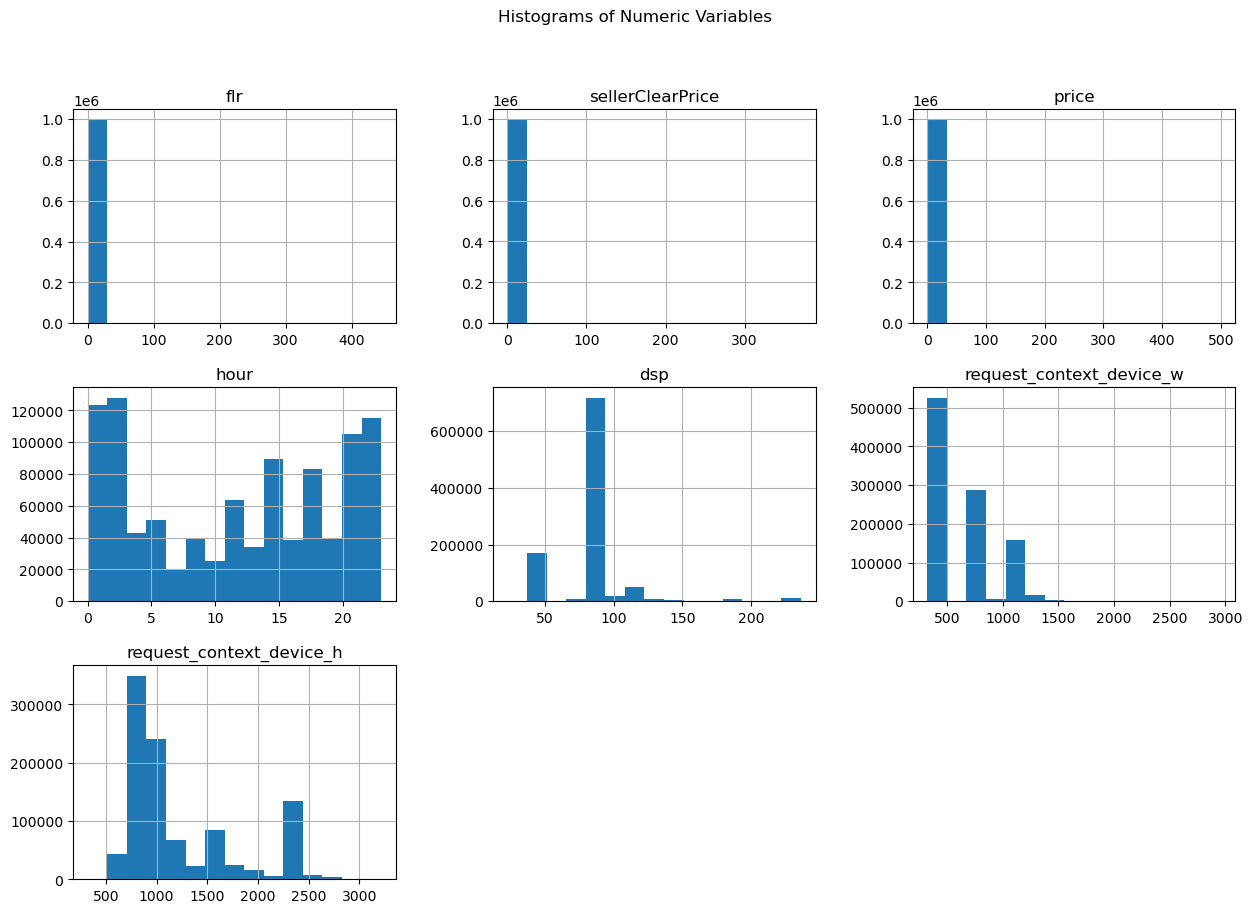

In [8]:
InitialEDA.plot_histograms(df, NUM_COLS)

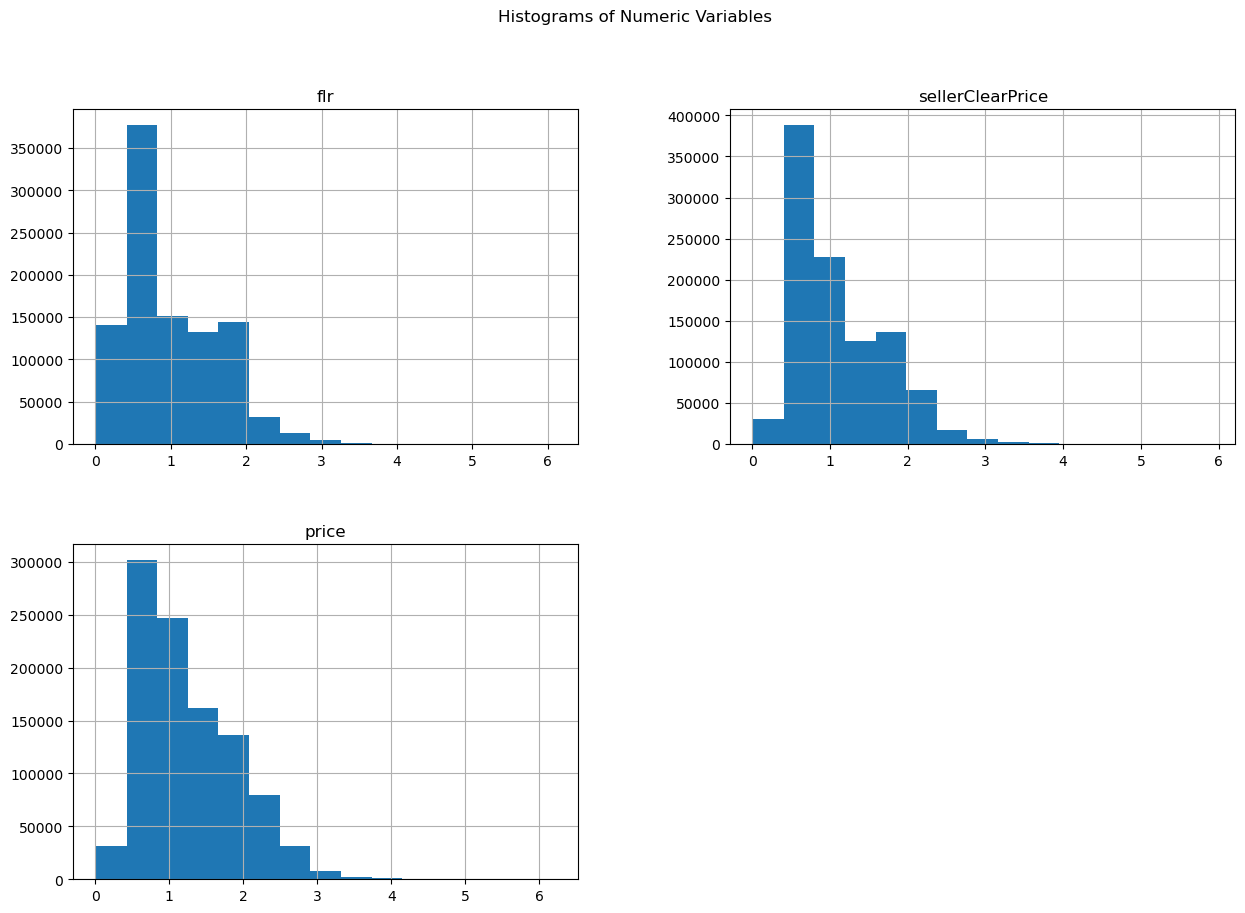

In [9]:
InitialEDA.plot_histograms(np.log1p(df[NUM_COLS]), NUM_COLS[:3]) #Log transformation for prices

## Dropped columns:

`ifa`: Too many missing values

`sdk`, `adt`, `dc`: Not informative

`ssp`: Unique value